# Yelp Restaurant Image Classifier (Transfer Learning Evaluation)
* Author: Peerapak Adsavakulchai
* Email: padsavak@uchicago.edu
* Purpose: University of Chicago MSCA 31009 Final Project


### Installation of Packages
Run if not already installed

In [1]:
!pip install tensorflow --quiet

In [2]:
!pip install -U efficientnet --quiet

In [3]:
!pip install keras-tuner --quiet

### Importing Packages and Dependencies

In [4]:
from google.cloud import storage

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
import numpy as np

import efficientnet.keras as efn

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

2023-05-11 22:18:24.103002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 22:18:25.345818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-11 22:18:25.345928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

### GCP Parameters

In [5]:
storage_client = storage.Client()
bucket_name = 'final-project-31009-peerapak-a'
bucket = storage_client.get_bucket(bucket_name)

### Data Processing

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

In [7]:
#Setting up paths to image files

path_train = '/home/jupyter/Data/Train Data/'
path_test = '/home/jupyter/Data/Test Data/'


#### Image Size: 224 x 224

In [8]:
train_generator224 = train_datagen.flow_from_directory(
    path_train, 
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (224, 224)
)


test_generator224 = test_datagen.flow_from_directory(
    path_test,  
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (224, 224))


Found 1379 images belonging to 4 classes.
Found 589 images belonging to 4 classes.


#### Image Size: 150 x 150

In [9]:
train_generator150 = train_datagen.flow_from_directory(
    path_train, 
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (150, 150)
)


test_generator150 = test_datagen.flow_from_directory(
    path_test,  
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (150, 150))


Found 1379 images belonging to 4 classes.
Found 589 images belonging to 4 classes.


## Exploring Data Distribution 
Use histograms

#### Training

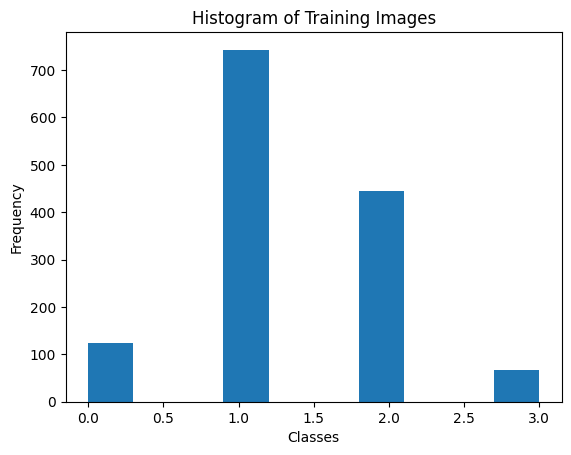

In [10]:
plt.hist(train_generator224.classes)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Training Images')

# Show the plot
plt.show()

#### Test

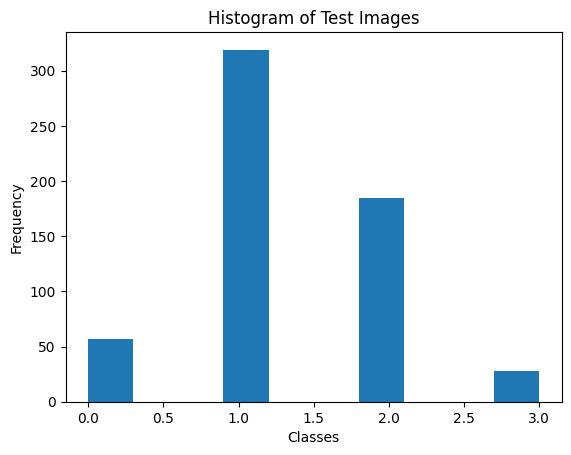

In [11]:
plt.hist(test_generator224.classes)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Test Images')

# Show the plot
plt.show()

## Loading Best Pre-trained Models 
Use when reloading this worksheet after closing out GCP Instance

In [12]:
path_model_save = '/home/jupyter/Best Model/'

In [13]:
VGG_load = tf.keras.models.load_model(path_model_save + "VGG.h5")
Inception_load = tf.keras.models.load_model(path_model_save + "Inception.h5")
RestNet_load = tf.keras.models.load_model(path_model_save + "RestNet.h5")
efn_load = tf.keras.models.load_model(path_model_save + "EFN.h5")

2023-05-11 22:18:28.368647: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-11 22:18:28.368707: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-11 22:18:28.368753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cnn-codes): /proc/driver/nvidia/version does not exist
2023-05-11 22:18:28.369070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the approp

## Predictions
* Predicting results from each model
* Create an ensemble predictions to test performance of an ensemble model

In [14]:
true_class = test_generator224.classes

In [15]:
models = [VGG_load, Inception_load, RestNet_load, efn_load]


In [16]:
#Predictions from each model 

preds_list = []

for model in models:
    
    if model == Inception_load:
        
        preds = model.predict(test_generator150)
        preds_list.append(preds)
        
    else:
        preds = model.predict(test_generator224)
        preds_list.append(preds)



19/19 [==============================] - 23s 1s/step


In [17]:
#Ensemble Predictions

preds_list.append(np.mean(preds_list, axis=0))


In [18]:
#Creating Predicted Classes
predicted_classes = []

for i in preds_list:
    predicted_classes.append(np.argmax(i, axis=1))



In [19]:
#Creating Predicted Probabilities

prediction_probs = []

for i in range(5):
    prediction_probs.append(
                preds_list[i][np.arange(len(predicted_classes[i])), predicted_classes[i]]
        )
    

## Results Evaluation 

Using:
* Accuracy
* Precision
* Recall

#### 1. VGG-16

In [20]:
#VGG16
print(classification_report(true_class, predicted_classes[0]))
print(accuracy_score(true_class, predicted_classes[0]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.54      1.00      0.70       319
           2       0.00      0.00      0.00       185
           3       0.00      0.00      0.00        28

    accuracy                           0.54       589
   macro avg       0.14      0.25      0.18       589
weighted avg       0.29      0.54      0.38       589

0.5398981324278438


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


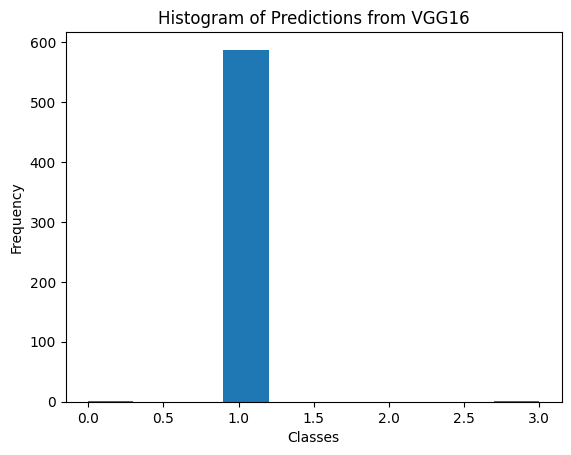

In [21]:
plt.hist(predicted_classes[0])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions from VGG16')

# Show the plot
plt.show()

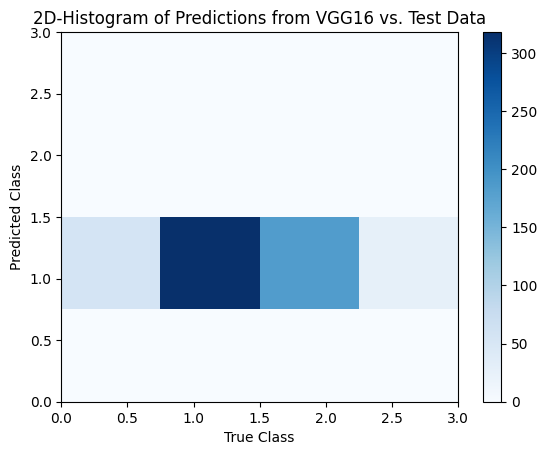

In [22]:
plt.hist2d(true_class, predicted_classes[0], bins=(4, 4), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('2D-Histogram of Predictions from VGG16 vs. Test Data')
plt.show()

#### 2. Inception

In [23]:
#Inception
print(classification_report(true_class, predicted_classes[1]))
print(accuracy_score(true_class, predicted_classes[1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.54      1.00      0.70       319
           2       0.00      0.00      0.00       185
           3       0.00      0.00      0.00        28

    accuracy                           0.54       589
   macro avg       0.14      0.25      0.18       589
weighted avg       0.29      0.54      0.38       589

0.5415959252971138


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


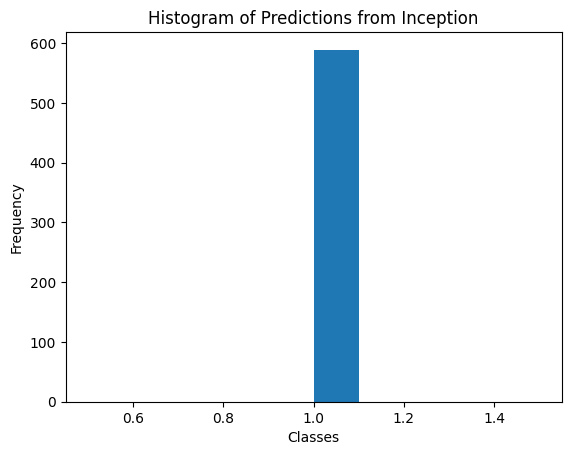

In [24]:
plt.hist(predicted_classes[1])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions from Inception')

# Show the plot
plt.show()

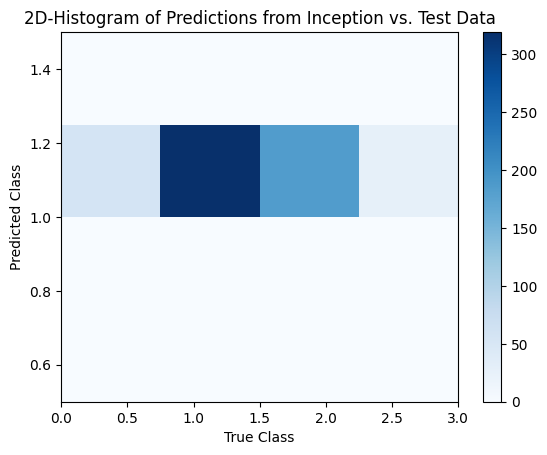

In [25]:
plt.hist2d(true_class, predicted_classes[1], bins=(4, 4), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('2D-Histogram of Predictions from Inception vs. Test Data')
plt.show()

#### 3. RestNet 50

In [26]:
#RestNet
print(classification_report(true_class, predicted_classes[2]))
print(accuracy_score(true_class, predicted_classes[2]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.54      1.00      0.70       319
           2       0.00      0.00      0.00       185
           3       0.00      0.00      0.00        28

    accuracy                           0.54       589
   macro avg       0.14      0.25      0.18       589
weighted avg       0.29      0.54      0.38       589

0.5415959252971138


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


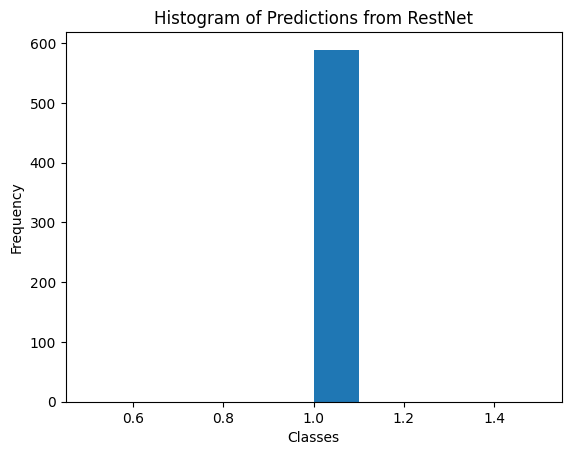

In [27]:
plt.hist(predicted_classes[2])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions from RestNet')

# Show the plot
plt.show()

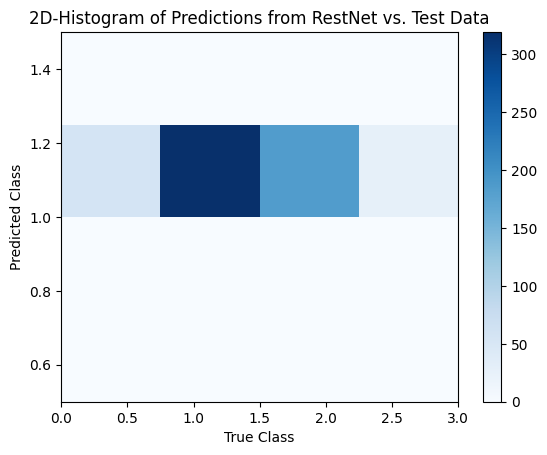

In [28]:
plt.hist2d(true_class, predicted_classes[2], bins=(4, 4), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('2D-Histogram of Predictions from RestNet vs. Test Data')
plt.show()

#### 4. EFN

In [29]:
#EFN
print(classification_report(true_class, predicted_classes[3]))
print(accuracy_score(true_class, predicted_classes[3]))

              precision    recall  f1-score   support

           0       0.18      0.18      0.18        57
           1       0.60      0.45      0.52       319
           2       0.33      0.49      0.39       185
           3       0.06      0.04      0.05        28

    accuracy                           0.42       589
   macro avg       0.29      0.29      0.28       589
weighted avg       0.45      0.42      0.42       589

0.41935483870967744


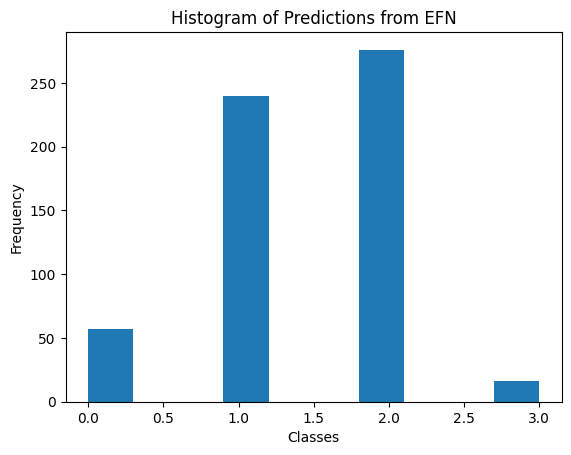

In [30]:
plt.hist(predicted_classes[3])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions from EFN')

# Show the plot
plt.show()

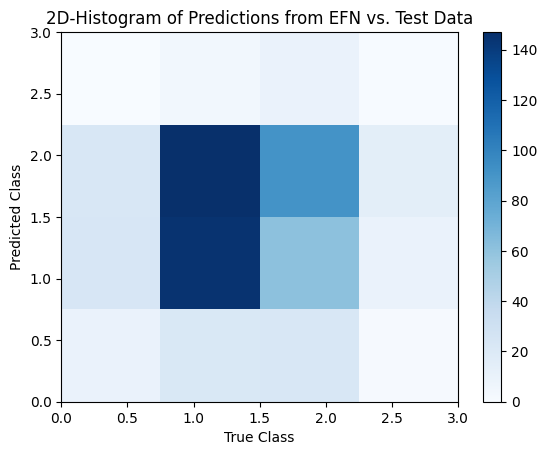

In [31]:
plt.hist2d(true_class, predicted_classes[3], bins=(4, 4), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('2D-Histogram of Predictions from EFN vs. Test Data')
plt.show()

#### 5. Ensemble

In [32]:
#Ensemble
print(classification_report(true_class, predicted_classes[4]))
print(accuracy_score(true_class, predicted_classes[4]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.54      1.00      0.70       319
           2       1.00      0.01      0.01       185
           3       0.00      0.00      0.00        28

    accuracy                           0.54       589
   macro avg       0.39      0.25      0.18       589
weighted avg       0.61      0.54      0.38       589

0.5432937181663837


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


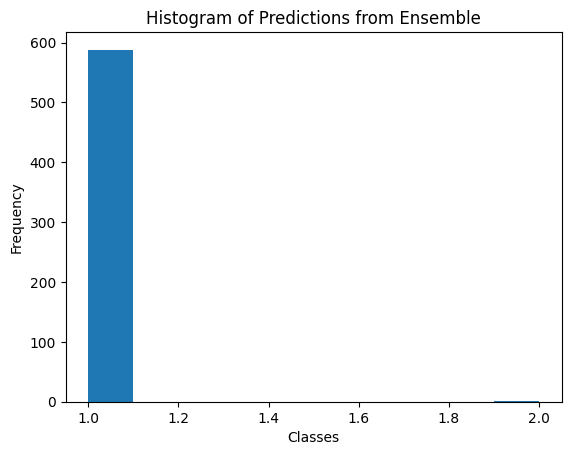

In [33]:
plt.hist(predicted_classes[4])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions from Ensemble')

# Show the plot
plt.show()

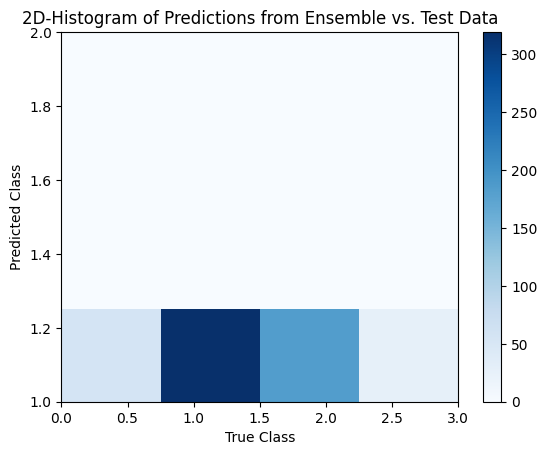

In [34]:
plt.hist2d(true_class, predicted_classes[4], bins=(4, 4), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('2D-Histogram of Predictions from Ensemble vs. Test Data')
plt.show()